## Prelimiary Operations

### Useful operations

In [1]:
import os
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [2]:
if os.path.exists("/kaggle/working/EfficientNet_experiments"):
    shutil.rmtree("/kaggle/working/EfficientNet_experiments")

In [3]:
if os.path.exists("/kaggle/working/EfficientNet"):
    shutil.rmtree("/kaggle/working/EfficientNet")

In [4]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [5]:
# to create a folder
import os
directory = "EfficientNet"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [9]:
labels = ['Species1',   # 0
          'Species2',   # 1
          'Species3',   # 2
          'Species4',   # 3
          'Species5',   # 4
          'Species6',   # 5
          'Species7',   # 6
          'Species8']   # 7

In [10]:
# Dataset folders 
dataset_dir = "../input/splitted-dataset-no-test/splitted_dataset_no_test"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation

# Use this for data augmentation
train_data_gen = ImageDataGenerator(rotation_range=20,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        fill_mode='reflect')


# Use this for no augmentation
#train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


## Model

In [12]:
!cd /kaggle/working/EfficieNet

/bin/bash: line 0: cd: /kaggle/working/EfficieNet: No such file or directory


In [14]:
# Download and plot the EfficientNet model
eff_net = tfk.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
)

eff_net.trainable = True # we are freezing the weights of the conv part, so that they are not updated
                            # during the training
#tfk.utils.plot_model(eff_net)

115277824/115263384 [==============================] - 4s 0us/step


In [15]:
input_shape = (96, 96, 3)
epochs = 300
learning_rate = 1e-4
l1=0
l2=0

In [16]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    efficient_net = eff_net(input_layer)    
    x = tfkl.GlobalAveragePooling2D()(efficient_net)
    x = tfkl.Dropout(0.2, seed=seed)(x)
    output_layer = tfkl.Dense(
        8, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
        # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='efficient_net_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 3, 3, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 28,529,919
Trainable params: 28,357,176
Non-trainable params: 172,743
_________________________________________________________________


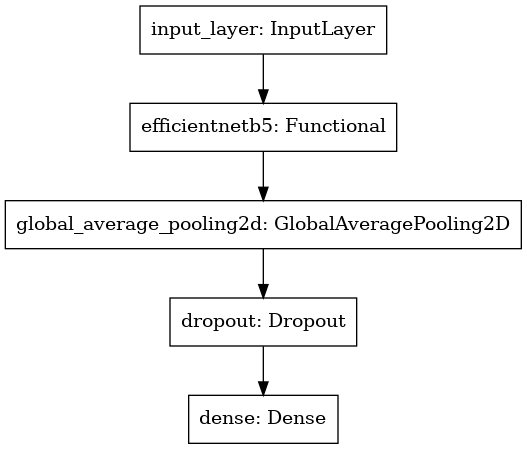

In [17]:
# Build model
model_name = "Efficient_net_all_trainable_only_GAP"

eff_net_model = build_model(input_shape)
eff_net_model.summary()
tfk.utils.plot_model(eff_net_model)

In [18]:
patience = 20

In [19]:
# Train the model
eff_net_model_history = eff_net_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/300
429/429 [==============================] - 87s 140ms/step - loss: 1.5823 - accuracy: 0.4097 - val_loss: 1.3721 - val_accuracy: 0.4919
Epoch 2/300
429/429 [==============================] - 56s 131ms/step - loss: 1.1775 - accuracy: 0.5822 - val_loss: 1.1230 - val_accuracy: 0.6134
Epoch 3/300
429/429 [==============================] - 56s 131ms/step - loss: 1.0081 - accuracy: 0.6294 - val_loss: 0.9043 - val_accuracy: 0.6701
Epoch 4/300
429/429 [==============================] - 56s 130ms/step - loss: 0.8750 - accuracy: 0.6874 - val_loss: 0.8414 - val_accuracy: 0.7060
Epoch 5/300
429/429 [==============================] - 56s 131ms/step - loss: 0.7678 - accuracy: 0.7287 - val_loss: 0.7824 - val_accuracy: 0.7269
Epoch 6/300
429/429 [==============================] - 57s 133ms/step - loss: 0.6906 - accuracy: 0.7599 - val_loss: 0.6431 - val_accuracy: 0.7697
Epoch 7/300
429/429 [==============================] - 57s 132ms/step - loss: 0.6244 - accuracy: 0.7864 - val_loss: 0.6395 -

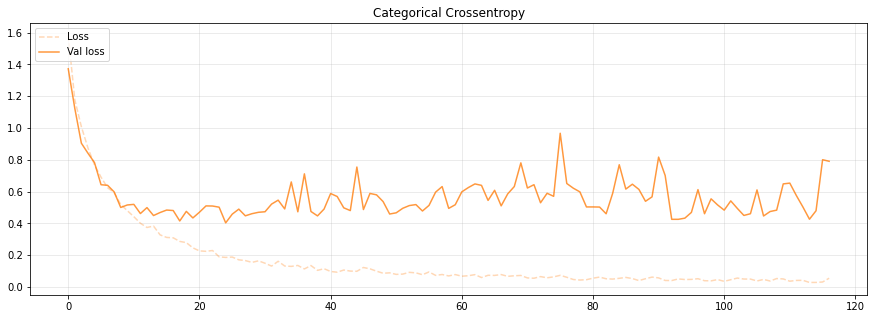

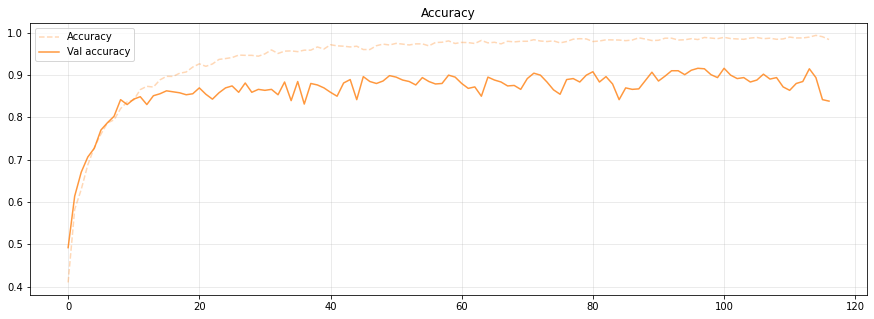

In [20]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig(model_name + "cat_cr_en.png")

plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig(model_name + "acc.png")

plt.show()

In [21]:
# Save the best model
eff_net_model.save(model_name)

In [22]:
# Make layers from 6d trainable
eff_net_model.get_layer('efficientnetb5').trainable = False
eff_net = eff_net_model.get_layer('efficientnetb5')
eff_net.trainable = True
set_trainable = False

for layer in eff_net.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, tfkl.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False
        
eff_net_model.summary()

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 3, 3, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 28,529,919
Trainable params: 18,498,128
Non-trainable params: 10,031,791
_________________________________________________________________


In [23]:
model_name = "Efficient_net_from_6d_trainable_only_GAP"

epochs = 500
patience = 30

In [24]:
# Train the model
eff_net_model_history = eff_net_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/500
429/429 [==============================] - 58s 134ms/step - loss: 0.0407 - accuracy: 0.9843 - val_loss: 0.5752 - val_accuracy: 0.8924
Epoch 2/500
429/429 [==============================] - 59s 138ms/step - loss: 0.0617 - accuracy: 0.9825 - val_loss: 0.4916 - val_accuracy: 0.8877
Epoch 3/500
429/429 [==============================] - 58s 134ms/step - loss: 0.0583 - accuracy: 0.9793 - val_loss: 0.5601 - val_accuracy: 0.8866
Epoch 4/500
429/429 [==============================] - 59s 137ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.5500 - val_accuracy: 0.8889
Epoch 5/500
429/429 [==============================] - 59s 138ms/step - loss: 0.0631 - accuracy: 0.9799 - val_loss: 0.4991 - val_accuracy: 0.8935
Epoch 6/500
429/429 [==============================] - 57s 133ms/step - loss: 0.0549 - accuracy: 0.9831 - val_loss: 0.4911 - val_accuracy: 0.9051
Epoch 7/500
429/429 [==============================] - 60s 139ms/step - loss: 0.0553 - accuracy: 0.9811 - val_loss: 0.4265 -

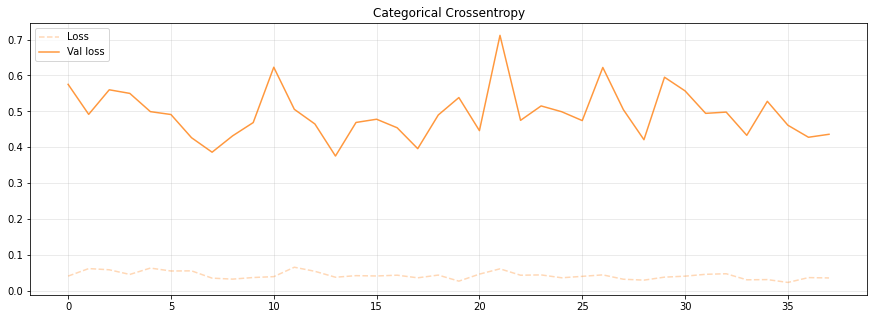

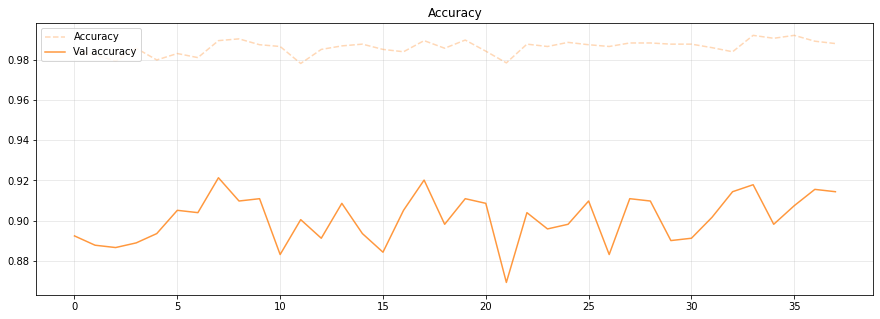

In [25]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig(model_name + "cat_cr_en.png")

plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig(model_name + "acc.png")

plt.show()

In [26]:
# Save model
eff_net_model.save(model_name)

## Training

In [27]:
# Evaluate on val
val_metrics = eff_net_model.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

108/108 [==============================] - 3s 29ms/step - loss: 0.3861 - accuracy: 0.9213

Val metrics
{'loss': 0.38605380058288574, 'accuracy': 0.9212962985038757}


In [28]:
# Make zip archive for download
import shutil
shutil.make_archive(model_name, 'zip', "/kaggle/working/EfficientNet")

'/kaggle/working/Efficient_net_from_6d_trainable_only_GAP.zip'